In [7]:
# Cell 1 - Imports, global configuration, and style

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Global style for plots
MAIN_COLOR = "#4A8DDC"            # Unified visualization color
sns.set_style("whitegrid")
sns.set_palette([MAIN_COLOR])     # Set seaborn palette to the single main color


In [8]:
# Cell 2 - Data loading and preparation

def load_and_prep_data(filepath):
    """
    Loads the orders CSV, cleans datetime columns, and builds a daily sales time series.

    Steps:
    1. Read CSV with ';' delimiter.
    2. Combine 'order date (DateOrders)' and 'order Time' into a single datetime.
    3. Replace Arabic AM/PM markers with English equivalents.
    4. Convert to datetime and set as index.
    5. Resample to daily frequency and fill missing days with 0 sales.

    Parameters
    ----------
    filepath : str
        Path to the CSV file.

    Returns
    -------
    df : pd.DataFrame
        Cleaned dataframe with a datetime index.
    ts_sales_daily : pd.Series
        Daily sales time series for 2017.
    """
    print("Loading and preparing data...")
    try:
        # Read raw dataset (semicolon separated)
        df = pd.read_csv("/content/orders_2017.csv", delimiter=';')

        # Combine date and time into one string
        datetime_str = df['order date (DateOrders)'] + ' ' + df['order Time']

        # Replace Arabic AM/PM markers with English equivalents if present
        datetime_str_cleaned = (
            datetime_str
            .str.replace('ص', 'AM')
            .str.replace('م', 'PM')
        )

        # Convert combined string to datetime objects
        df['datetime'] = pd.to_datetime(
            datetime_str_cleaned,
            format='%d/%m/%Y %I:%M:%S %p'
        )

        # Set datetime as index for resampling
        df.set_index('datetime', inplace=True)

        # Resample to daily frequency and sum sales per day
        ts_sales_daily = df['Sales'].resample('D').sum()

        # Build a full 2017 daily range and fill any missing days with 0
        full_date_range = pd.date_range(
            start='2017-01-01',
            end='2017-12-31',
            freq='D'
        )
        ts_sales_daily = ts_sales_daily.reindex(full_date_range).fillna(0)

        print("Data loaded and prepared successfully.")
        return df, ts_sales_daily

    except Exception as e:
        # In case of any error, print it and return None
        print(f"Error loading data: {e}")
        return None, None


In [9]:
# Cell 3 - Time-series analysis (trend plots + seasonal decomposition)

def analyze_time_series(ts_sales_daily):
    """
    Performs time-series analysis on the daily sales:
    - Weekly and monthly aggregations
    - Daily, weekly, and monthly trend plots
    - Seasonal decomposition (weekly pattern)

    Parameters
    ----------
    ts_sales_daily : pd.Series
        Daily sales time series.
    """
    print("\n--- Starting Time-Series Analysis ---")

    # Aggregate to weekly and monthly series for smoother trends
    ts_sales_weekly = ts_sales_daily.resample('W').sum()
    ts_sales_monthly = ts_sales_daily.resample('MS').sum()

    # 1. Daily Sales Trend
    plt.figure(figsize=(14, 7))
    plt.plot(ts_sales_daily, label='Daily Sales', color=MAIN_COLOR)
    plt.title('Daily Sales Trend (2017)', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Weekly Sales Trend
    plt.figure(figsize=(14, 7))
    plt.plot(ts_sales_weekly, label='Weekly Sales', color=MAIN_COLOR)
    plt.title('Weekly Sales Trend (2017)', fontsize=16)
    plt.xlabel('Week')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Monthly Sales Trend
    plt.figure(figsize=(14, 7))
    plt.plot(ts_sales_monthly, label='Monthly Sales', color=MAIN_COLOR, marker='o')
    plt.title('Monthly Sales Trend (2017)', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Sales')

    # Format x-axis as month names (e.g., Jan, Feb, ...)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 4. Seasonal Decomposition (Weekly pattern with period=7 days)
    decomposition = seasonal_decompose(ts_sales_daily, model='additive', period=7)
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    fig.suptitle('Seasonal Decomposition (Weekly Pattern)', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


In [10]:
# Cell 4 - Market, segment, and category analysis

def analyze_market_segment(df):
    """
    Performs market and segment analysis:
    - Total sales by market
    - Total sales by customer segment
    - Monthly sales by top product categories (stacked area)
    - Top 10 categories by total sales

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned dataframe with 'Sales' and categorical fields.
    """
    print("\n--- Starting Market & Segment Analysis ---")

    # 1. Sales by Market
    market_sales = (
        df.groupby('Market')['Sales']
        .sum()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(12, 7))
    sns.barplot(
        x=market_sales.values,
        y=market_sales.index,
        color=MAIN_COLOR
    )
    plt.title('Total Sales by Market (2017)', fontsize=16)
    plt.xlabel('Total Sales')
    plt.ylabel('Market')
    plt.tight_layout()
    plt.show()

    # 2. Sales by Customer Segment
    segment_sales = (
        df.groupby('Customer Segment')['Sales']
        .sum()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=segment_sales.values,
        y=segment_sales.index,
        color=MAIN_COLOR
    )
    plt.title('Total Sales by Customer Segment (2017)', fontsize=16)
    plt.xlabel('Total Sales')
    plt.ylabel('Customer Segment')
    plt.tight_layout()
    plt.show()

    # 3. Monthly sales by top Product Categories (stacked area plot)
    # Group by category and resample by month start
    monthly_cat = (
        df.groupby('Category Name')['Sales']
        .resample('MS')
        .sum()
        .unstack(level='Category Name')
        .fillna(0)
    )

    # Select top 6 categories by total sales
    top_cats = (
        monthly_cat.sum()
        .sort_values(ascending=False)
        .index[:6]
    )
    monthly_cat_top = monthly_cat[top_cats]

    plt.figure(figsize=(14, 8))
    # Use the same main color repeated (one per category)
    colors = [MAIN_COLOR] * monthly_cat_top.shape[1]
    plt.stackplot(
        monthly_cat_top.index,
        monthly_cat_top.T,
        labels=monthly_cat_top.columns,
        colors=colors,
        alpha=0.8
    )
    plt.title('Monthly Sales by Top Product Category', fontsize=16)
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Total Sales by Category (Top 10 bar chart)
    cat_total = (
        df.groupby('Category Name')['Sales']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=cat_total.values,
        y=cat_total.index,
        color=MAIN_COLOR
    )
    plt.title('Top 10 Product Categories by Sales', fontsize=16)
    plt.xlabel('Total Sales')
    plt.ylabel('Category Name')
    plt.tight_layout()
    plt.show()


In [11]:
# Cell 5 - Dashboard-style overview (single figure with multiple views)

def show_dashboard(df, ts_sales_daily):
    """
    Creates a simple visual 'dashboard' with multiple key views:
    - Top-left: Daily sales trend (full year)
    - Top-right: Weekly sales trend (smoother view)
    - Bottom-left: Total sales by Market
    - Bottom-right: Top 5 Categories by total sales

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned dataframe with 'Sales' and categorical columns.
    ts_sales_daily : pd.Series
        Daily sales time series.
    """
    print("\n--- Dashboard Overview ---")

    # Aggregations
    ts_sales_weekly = ts_sales_daily.resample('W').sum()
    market_sales = (
        df.groupby('Market')['Sales']
        .sum()
        .sort_values(ascending=False)
    )
    cat_total = (
        df.groupby('Category Name')['Sales']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

    # Create 2x2 dashboard figure
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle("Sales Dashboard - 2017 Overview", fontsize=18, y=0.98)

    # --- Top-left: Daily sales trend ---
    ax = axes[0, 0]
    ax.plot(ts_sales_daily, color=MAIN_COLOR)
    ax.set_title("Daily Sales", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.grid(True, alpha=0.3)

    # --- Top-right: Weekly sales trend ---
    ax = axes[0, 1]
    ax.plot(ts_sales_weekly, color=MAIN_COLOR, marker='o')
    ax.set_title("Weekly Sales", fontsize=14)
    ax.set_xlabel("Week")
    ax.set_ylabel("Sales")
    ax.grid(True, alpha=0.3)

    # --- Bottom-left: Sales by Market ---
    ax = axes[1, 0]
    sns.barplot(
        x=market_sales.values,
        y=market_sales.index,
        color=MAIN_COLOR,
        ax=ax
    )
    ax.set_title("Total Sales by Market", fontsize=14)
    ax.set_xlabel("Total Sales")
    ax.set_ylabel("Market")

    # --- Bottom-right: Top 5 Categories ---
    ax = axes[1, 1]
    sns.barplot(
        x=cat_total.values,
        y=cat_total.index,
        color=MAIN_COLOR,
        ax=ax
    )
    ax.set_title("Top 5 Categories by Sales", fontsize=14)
    ax.set_xlabel("Total Sales")
    ax.set_ylabel("Category")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [12]:
# Cell 5 - Forecasting models (Linear Regression, SES, Holt-Winters, SARIMA)

def run_forecasting_models(ts_sales_daily):
    """
    Builds, evaluates, and uses multiple forecasting models:
    - Linear Regression on time index
    - Simple Exponential Smoothing (SES)
    - Holt-Winters (additive trend + additive seasonality)
    - SARIMA

    Uses weekly sales aggregated from the daily series.
    Splits data into training and testing, evaluates using RMSE and MAPE,
    and then retrains the best model on the full data to forecast 6 months ahead.

    Parameters
    ----------
    ts_sales_daily : pd.Series
        Daily sales time series.
    """
    print("\n--- Starting Forecasting Models ---")

    # Aggregate to weekly sales (more stable for forecasting)
    # Keep first 52 weeks to represent one full year
    ts_sales = ts_sales_daily.resample('W').sum().iloc[:52]

    # Train-test split (e.g., first 42 weeks for training, last 10 for testing)
    split_point = 42
    train = ts_sales.iloc[:split_point]
    test = ts_sales.iloc[split_point:]

    results = {}  # Dictionary to collect metrics for each model

    # ---------------------------------------------------------
    # Model 1: Linear Regression on time index
    # ---------------------------------------------------------
    # Time index as numeric feature
    X_train = np.arange(len(train)).reshape(-1, 1)
    y_train = train.values
    X_test = np.arange(len(train), len(ts_sales)).reshape(-1, 1)

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    preds_lr = model_lr.predict(X_test)

    results['Linear Regression'] = {
        'RMSE': np.sqrt(mean_squared_error(test.values, preds_lr)),
        'MAPE': mean_absolute_percentage_error(test.values, preds_lr)
    }

    # ---------------------------------------------------------
    # Model 2: Simple Exponential Smoothing (SES)
    # ---------------------------------------------------------
    model_ses = SimpleExpSmoothing(
        train,
        initialization_method='estimated'
    ).fit()

    preds_ses = model_ses.forecast(len(test))

    results['Simple Exp Smoothing'] = {
        'RMSE': np.sqrt(mean_squared_error(test.values, preds_ses)),
        'MAPE': mean_absolute_percentage_error(test.values, preds_ses)
    }

    # ---------------------------------------------------------
    # Model 3: Holt-Winters (additive trend + additive seasonality)
    # ---------------------------------------------------------
    model_hw = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=4  # 4 weeks ~ 1 month
    ).fit()

    preds_hw = model_hw.forecast(len(test))

    results['Holt-Winters'] = {
        'RMSE': np.sqrt(mean_squared_error(test.values, preds_hw)),
        'MAPE': mean_absolute_percentage_error(test.values, preds_hw)
    }

    # ---------------------------------------------------------
    # Model 4: SARIMA
    # ---------------------------------------------------------
    try:
        model_sarima = SARIMAX(
            train,
            order=(1, 0, 1),
            seasonal_order=(1, 1, 1, 4)
        ).fit(disp=False)

        preds_sarima = model_sarima.get_forecast(steps=len(test)).predicted_mean

        results['SARIMA'] = {
            'RMSE': np.sqrt(mean_squared_error(test.values, preds_sarima)),
            'MAPE': mean_absolute_percentage_error(test.values, preds_sarima)
        }
    except Exception as e:
        print(f"SARIMA failed: {e}")

    # ---------------------------------------------------------
    # Evaluation summary
    # ---------------------------------------------------------
    results_df = pd.DataFrame(results).T
    print("\nModel Performance (Weekly Forecasting):")
    print(results_df)

    # Choose best model by lowest MAPE
    best_model_name = results_df['MAPE'].idxmin()
    print(f"\nBest Model (by MAPE): {best_model_name}")

    # ---------------------------------------------------------
    # Final forecast using the best model (next 26 weeks ≈ 6 months)
    # ---------------------------------------------------------
    n_steps = 26
    forecast_index = pd.date_range(
        start=ts_sales.index[-1] + pd.Timedelta(weeks=1),
        periods=n_steps,
        freq='W'
    )

    final_forecast = None

    # Retrain the selected model on the full weekly data
    if best_model_name == 'SARIMA':
        model_final = SARIMAX(
            ts_sales,
            order=(1, 0, 1),
            seasonal_order=(1, 1, 1, 4)
        ).fit(disp=False)
        final_forecast = model_final.get_forecast(steps=n_steps).predicted_mean

    elif best_model_name == 'Simple Exp Smoothing':
        model_final = SimpleExpSmoothing(ts_sales).fit()
        final_forecast = model_final.forecast(n_steps)

    elif best_model_name == 'Holt-Winters':
        model_final = ExponentialSmoothing(
            ts_sales,
            trend='add',
            seasonal='add',
            seasonal_periods=4
        ).fit()
        final_forecast = model_final.forecast(n_steps)

    else:  # Linear Regression fallback
        X_full = np.arange(len(ts_sales)).reshape(-1, 1)
        model_lr.fit(X_full, ts_sales.values)
        X_future = np.arange(len(ts_sales), len(ts_sales) + n_steps).reshape(-1, 1)
        final_forecast = model_lr.predict(X_future)

    # Ensure final_forecast is a pandas Series with the forecast_index
    if not isinstance(final_forecast, pd.Series):
        final_forecast = pd.Series(final_forecast, index=forecast_index)
    else:
        final_forecast.index = forecast_index

    # ---------------------------------------------------------
    # Plot final 6-month forecast vs. historical weekly data
    # ---------------------------------------------------------
    plt.figure(figsize=(16, 8))

    # Historical weekly sales
    plt.plot(
        ts_sales,
        label='Actual Sales (2017)',
        color=MAIN_COLOR,
        marker='o'
    )

    # Forecast (same color, different linestyle and alpha)
    plt.plot(
        final_forecast,
        label='Forecast (Next 6 Months)',
        color=MAIN_COLOR,
        linestyle='--',
        marker='o',
        alpha=0.7
    )

    plt.title(f'6-Month Sales Forecast using {best_model_name}', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Loading and preparing data...
Data loaded and prepared successfully.

--- Starting Time-Series Analysis ---


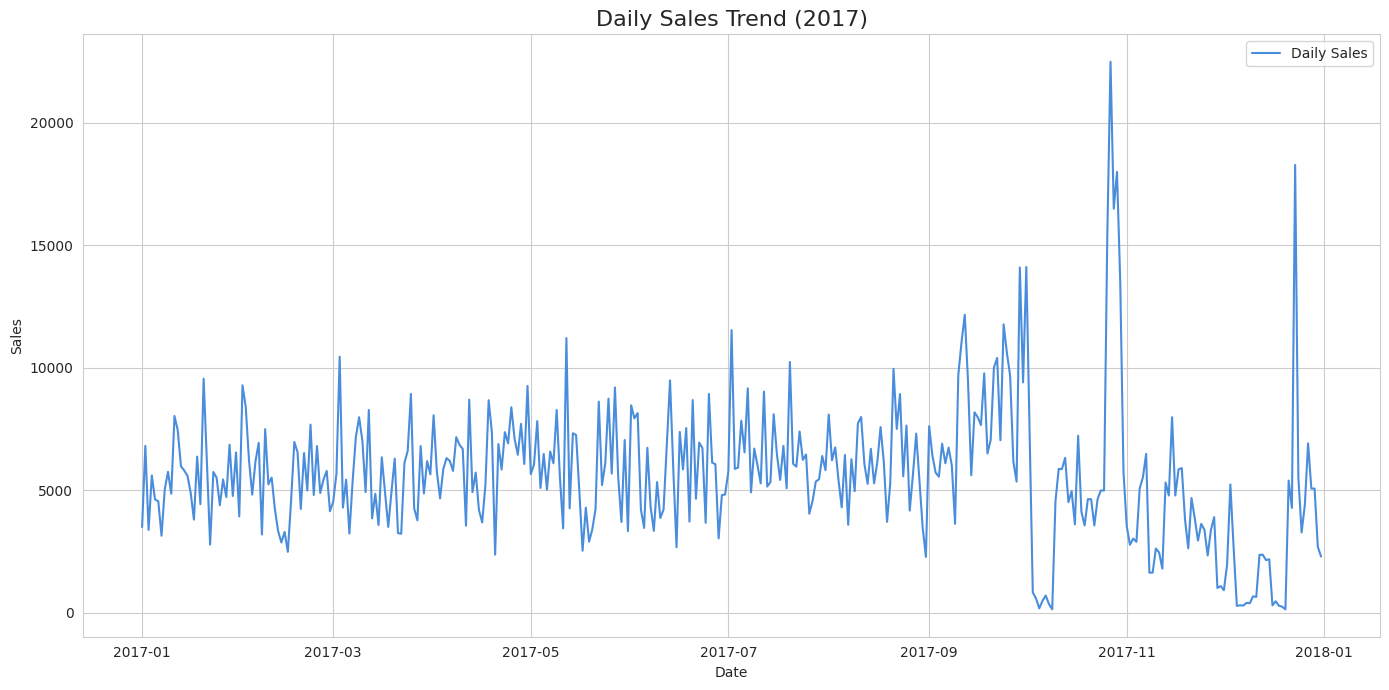

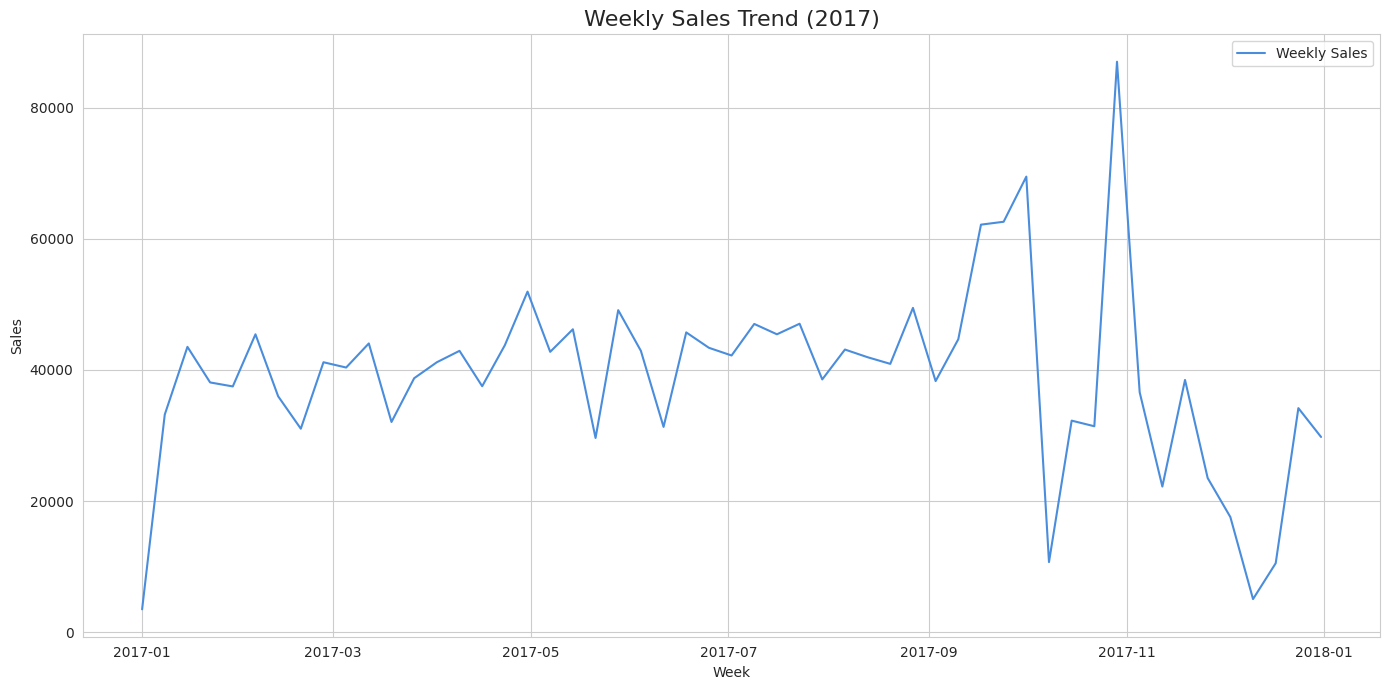

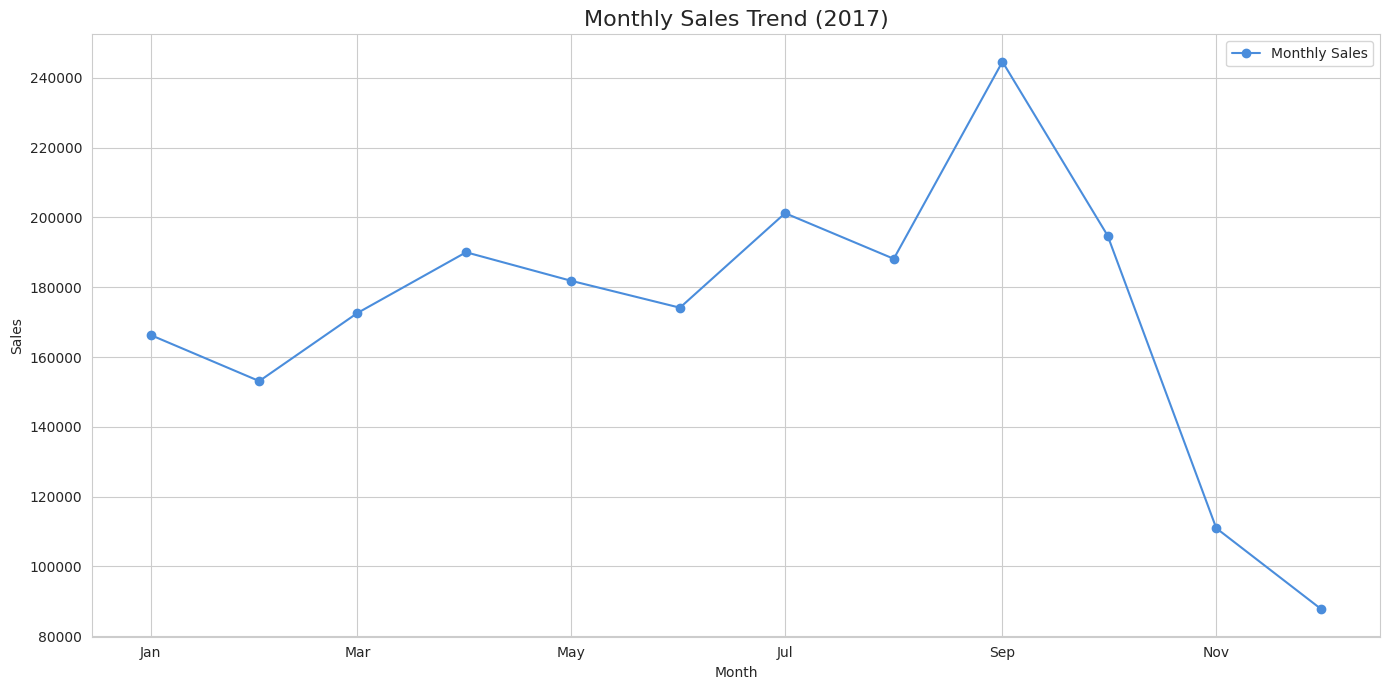

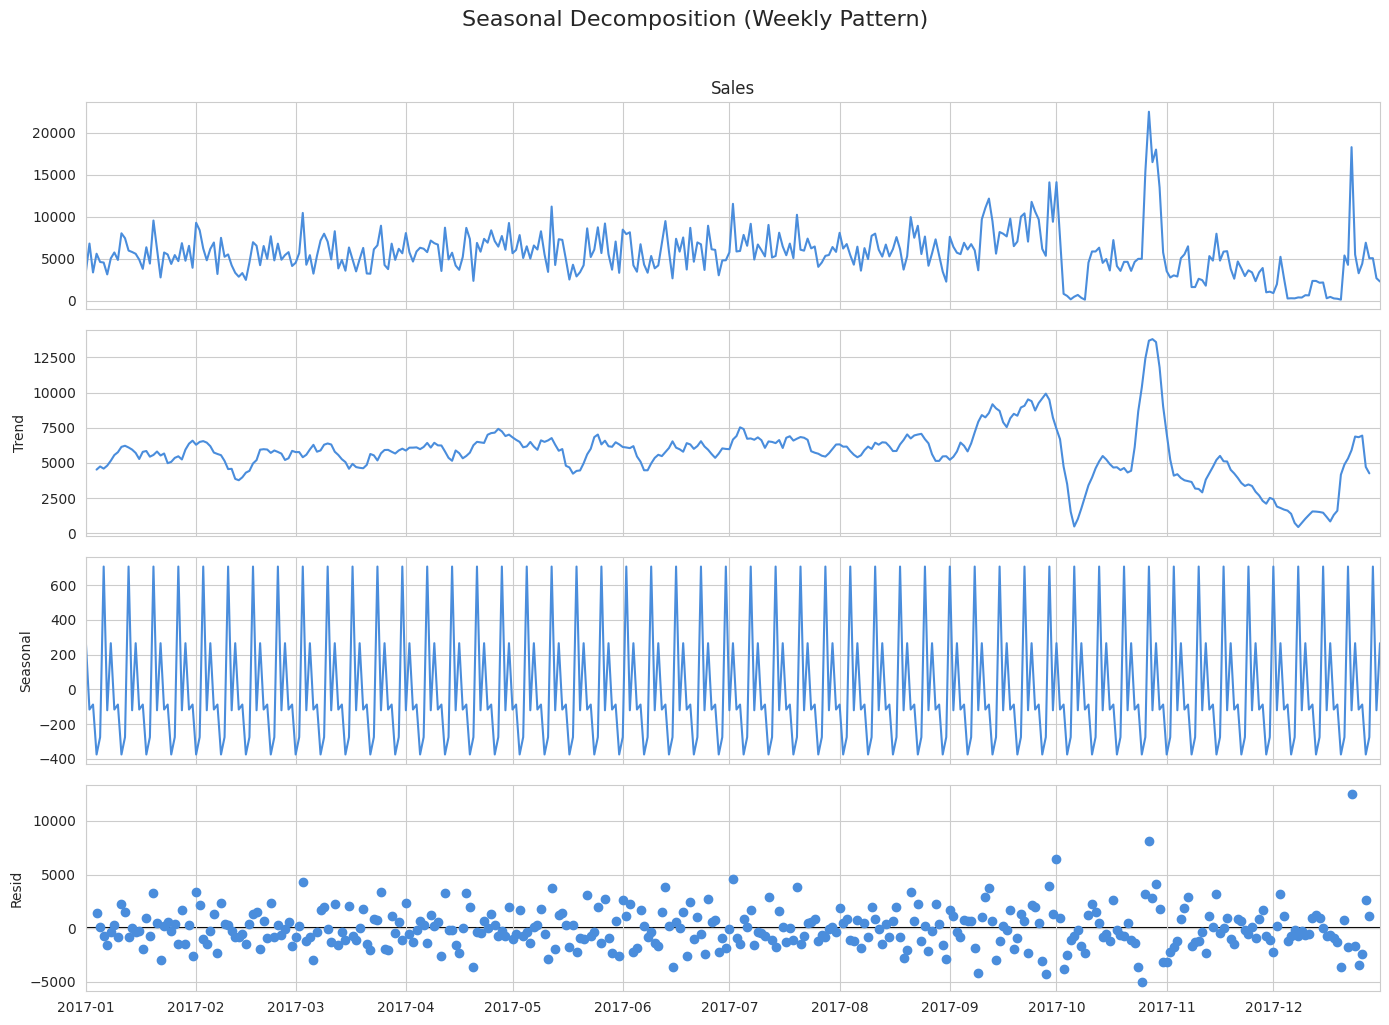


--- Starting Market & Segment Analysis ---


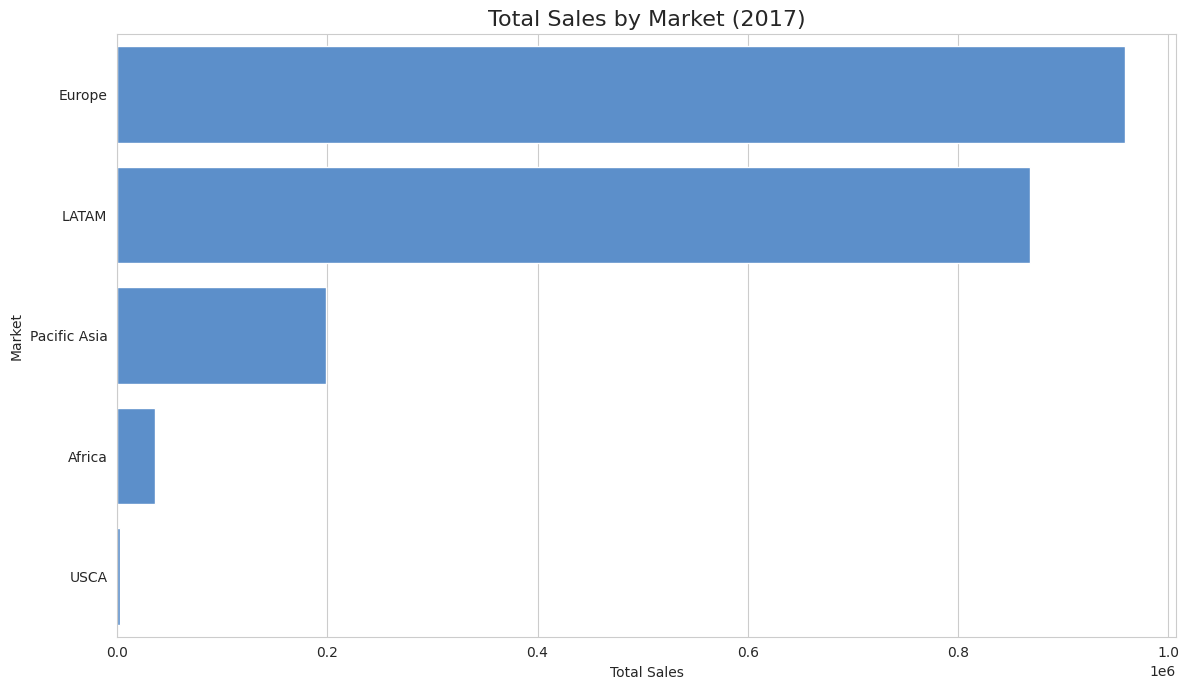

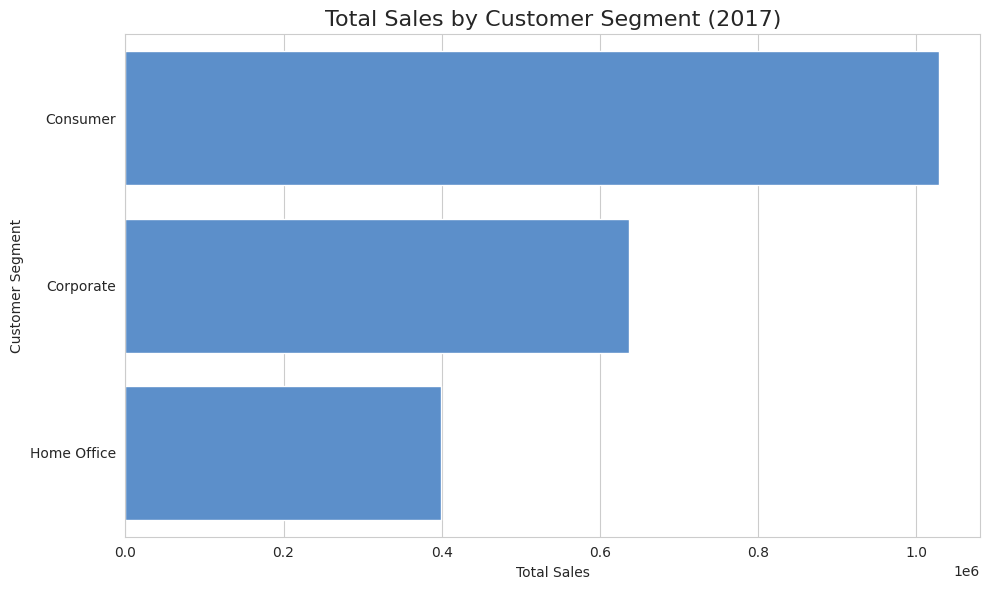

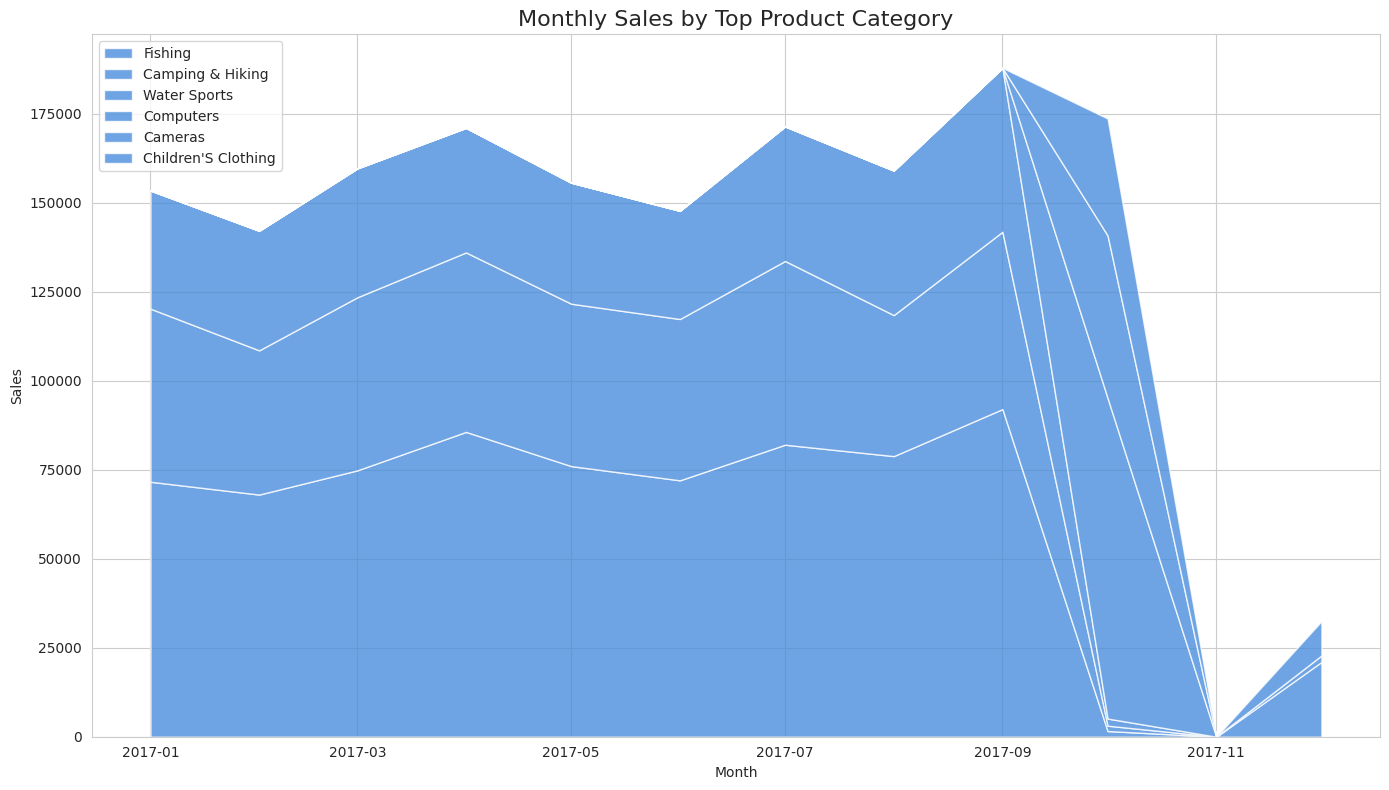

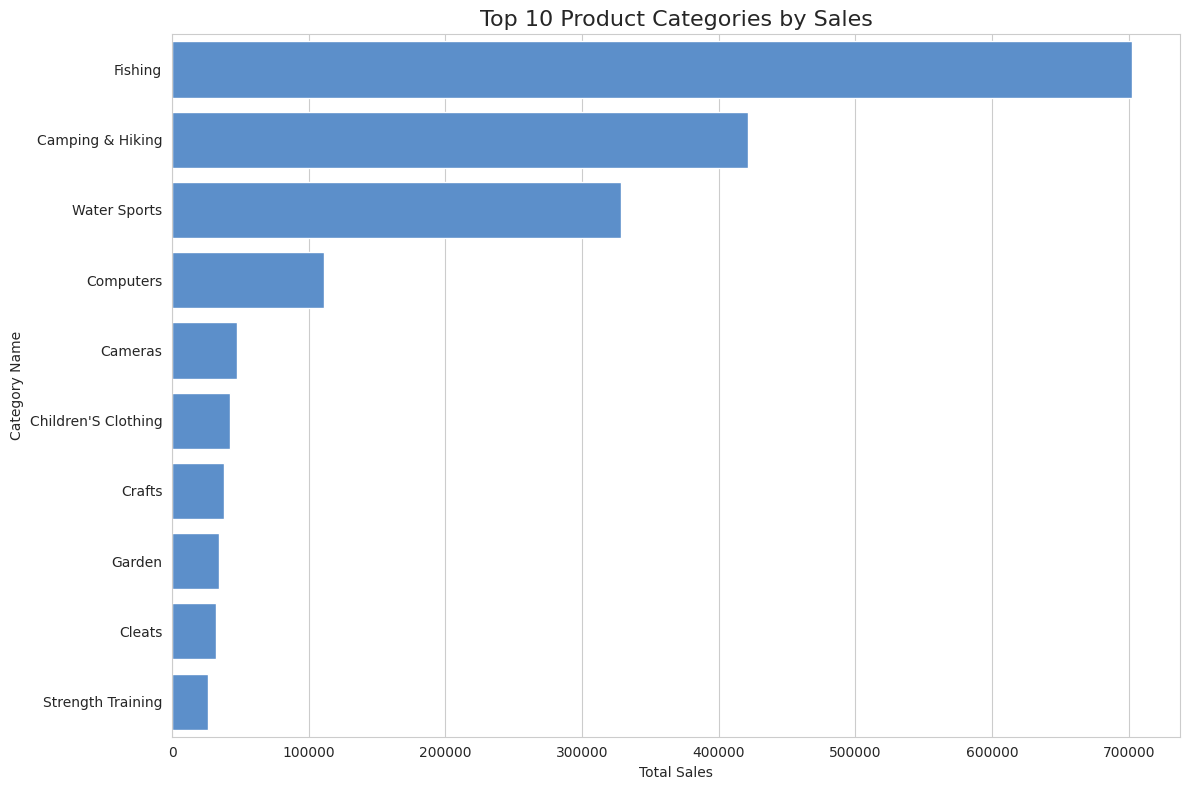


--- Dashboard Overview ---


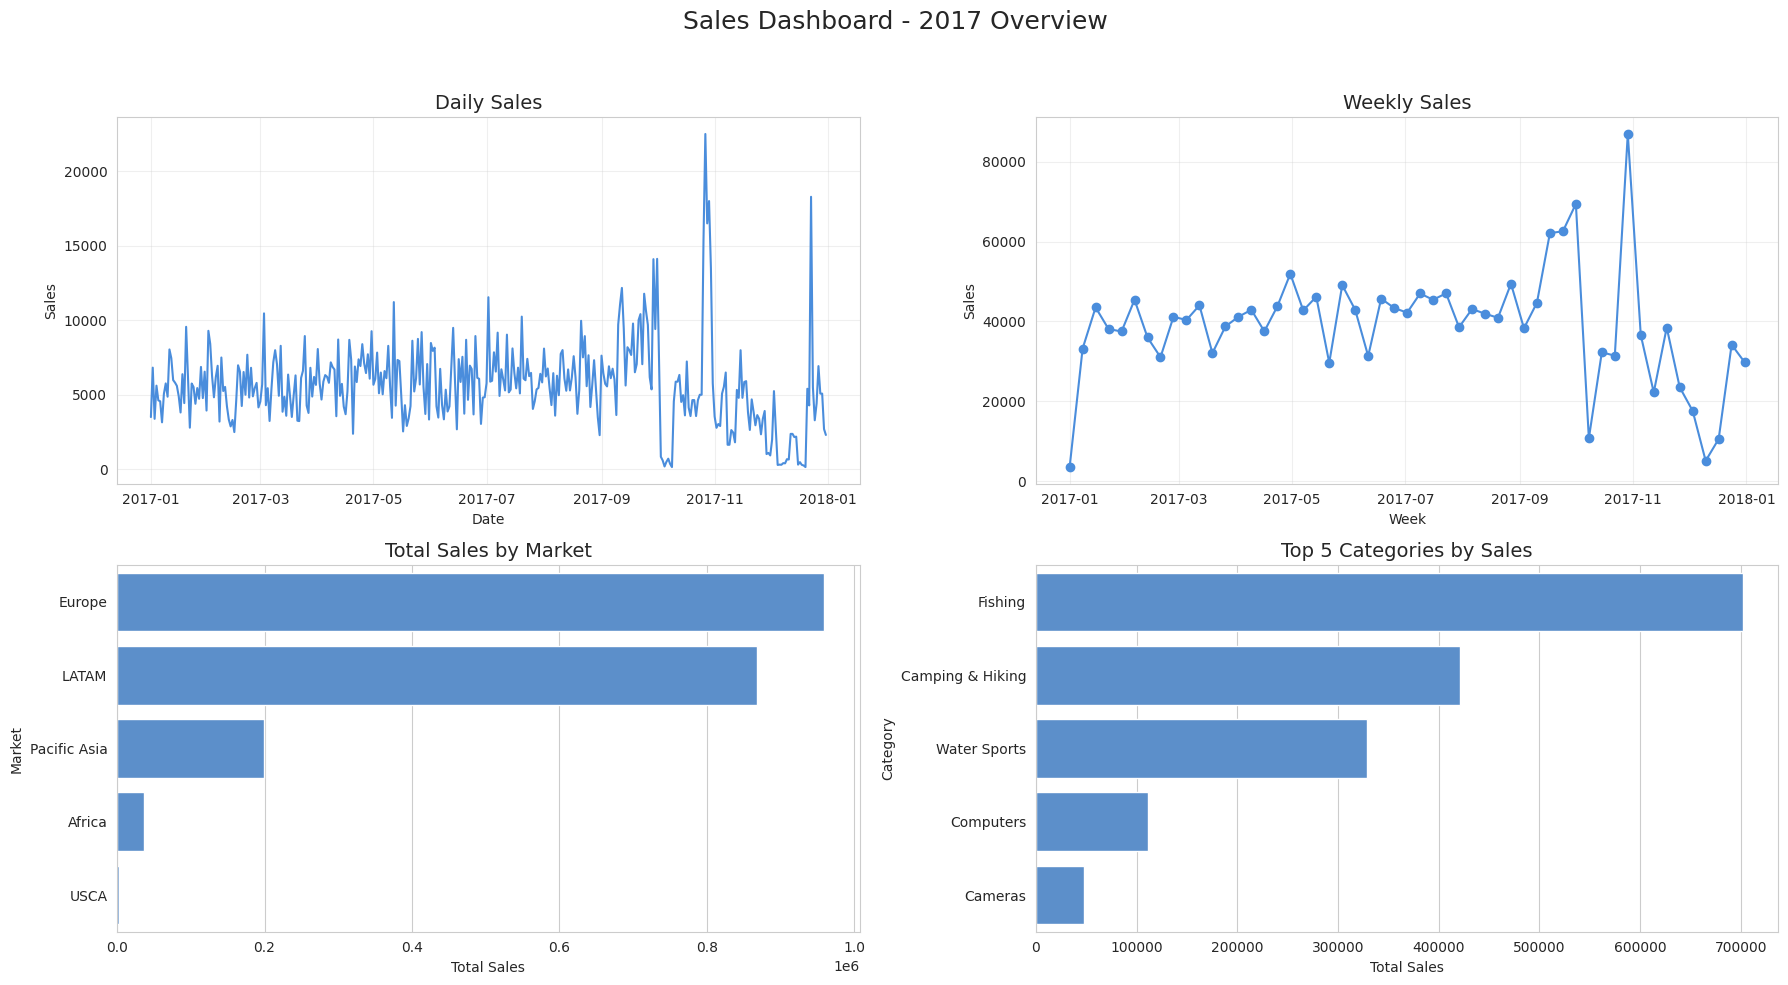


--- Starting Forecasting Models ---

Model Performance (Weekly Forecasting):
                              RMSE      MAPE
Linear Regression     28822.755777  1.881761
Simple Exp Smoothing  25008.007885  1.540919
Holt-Winters          29219.978934  1.898758
SARIMA                23814.662309  1.361773

Best Model (by MAPE): SARIMA


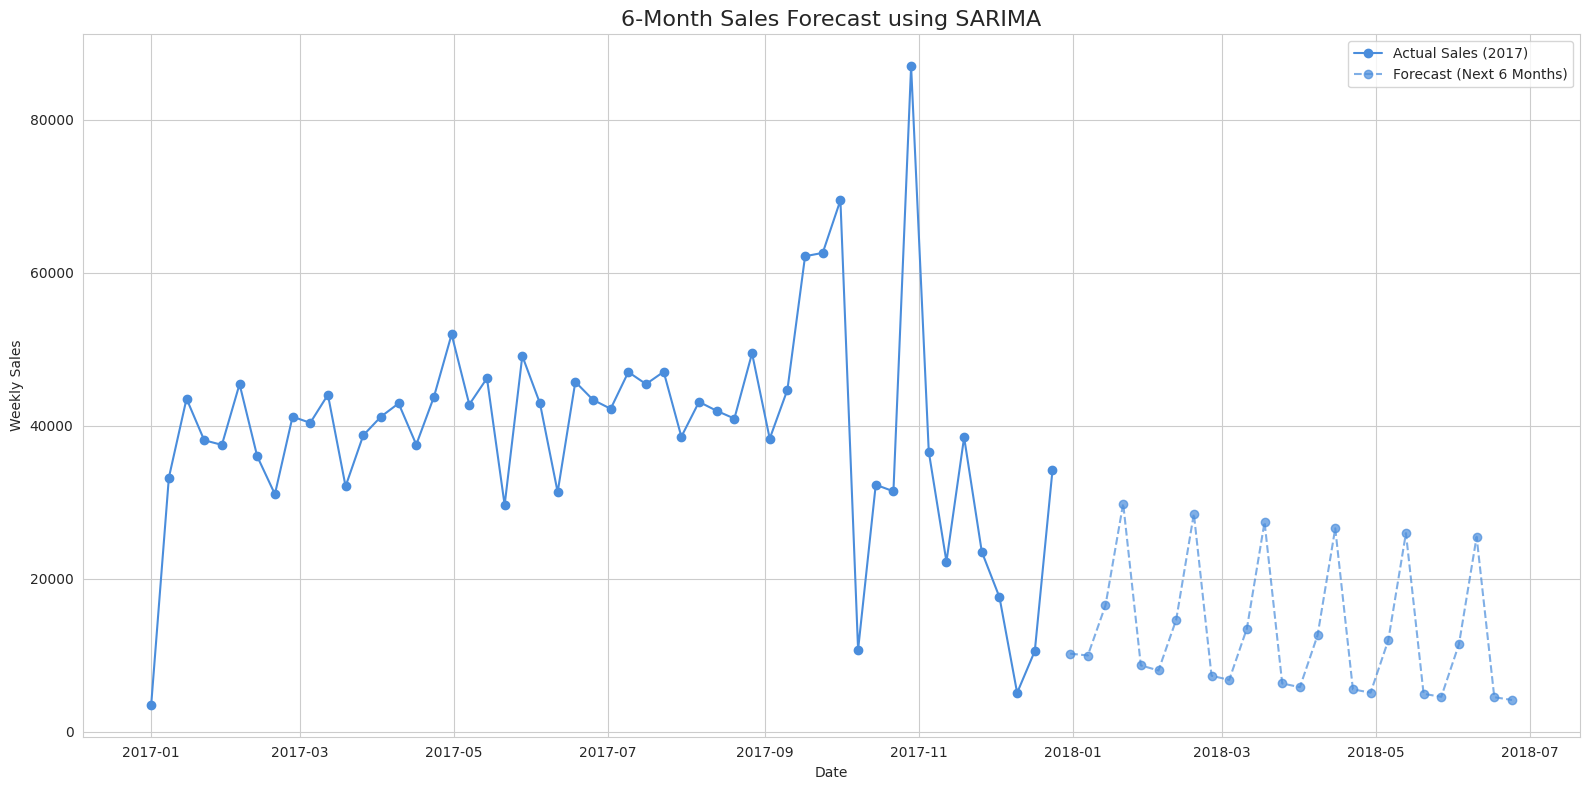


All tasks complete. Visuals should appear under each cell.


In [13]:
# Cell 6 - Main execution block

if __name__ == "__main__":
    # Path to the input CSV file
    file_path = "orders_2017.csv"   # Make sure this file exists in the working directory

    # Load and prepare data
    df_clean, ts_daily = load_and_prep_data(file_path)

    # Run analyses and forecasting only if data loaded successfully
    if df_clean is not None:
        analyze_time_series(ts_daily)
        analyze_market_segment(df_clean)
        show_dashboard(df_clean, ts_daily)      # <-- dashboard call
        run_forecasting_models(ts_daily)
        print("\nAll tasks complete. Visuals should appear under each cell.")
    else:
        print("Terminated: data could not be loaded.")
